In [116]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization, Dropout, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [117]:
class Encoder(Layer):
    def __init__(self, num_conv_layers, conv_units, encoder_output_dim, input_dim=None,
                 dropout_rate=None, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        
        self.input_layer = Input(shape=(self.input_dim))
        self.conv_layers = []
        for i in range(num_conv_layers):
            conv_layer = Conv2D(filters = conv_units, 
                                kernel_size = (3, 3), 
                                strides = 2,
                                padding = 'same',
                                activation='relu',
                                name = f'encode_conv_{i}')
            self.conv_layers.append(conv_layer)
        self.output_layer = Dense(encoder_output_dim)
            

    def call(self, inputs):
        encoder_layer = self.input_layer(inputs)
        for conv_layer in self.conv_layers:
            encoder_layer = conv_layer(encoder_layer)
            encoder_layer = BatchNormalization(encoder_layer)
            if dropout_rate is not None:
                encoder_layer = Dropout(rate=dropout_rate)(encoder_layer)
            
        encoder_layer = Flatten(encoder_layer)
        output_layer = self.output_layer(encoder_layer)
        return output_layer
    
    
def Decoder(Layers):
    def __init__(self, num_conv_layers, conv_units, encoder_output_dim, 
                 dropout_rate=None, name='decoder', **kwargs):
        self.decoder_input = Input(shape=(encoder_output_dim))
        self.dense = Dense(np.prod())
    
    
class Autoencoder(Model):
    def __init__(self, num_conv_layers, conv_units, encoder_output_dim, input_dim=None,
                 dropout_rate=None, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = Encoder(num_conv_layers = num_conv_layers, 
                               conv_units = conv_units, 
                               encoder_output_dim = encoder_output_dim, 
                               input_dim = input_dim,
                               dropout_rate = dropout_rate)
        
    def model(self):
        input_layer = Input(Input(shape=(24, 24, 3)))
        return Model(input_layer, self.call(input_layer))
    
        
    def call(self, inputs):
        return self.encoder(inputs)

In [118]:
model = Autoencoder(num_conv_layers=3, conv_units=5, encoder_output_dim=10, input_dim=24)

In [165]:
num_conv_layers = 4
conv_units = 64
encoder_output_dim=2
strides = [1,2,2,1]
input_dim=(28, 28, 1)
dropout_rate=0.2

encoder_input = Input(shape=input_dim)
x = encoder_input
for i in range(num_conv_layers):
    conv_layer = Conv2D(filters=conv_units,
                        kernel_size=(3, 3),
                        strides=strides[i],
                        padding='same',
                        activation='relu',
                        name=f'encoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

shape_before_flat = K.int_shape(x)[1:]
x = Flatten()(x)
dense_layer = Dense(encoder_output_dim, name='encoder_output')
encoder_output = dense_layer(x)

encoder_model = Model(encoder_input, encoder_output)
encoder_model.summary()

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        36928     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_13 (Flatten)         (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)               

In [176]:
decoder_input = Input(shape=encoder_output_dim)
x = Dense(np.prod(shape_before_flat))(decoder_input)
x = Reshape(shape_before_flat)(x)

for i in range(num_conv_layers - 1):
    conv_layer = Conv2DTranspose(filters=conv_units,
                                 kernel_size=(3, 3),
                                 strides=strides[i], 
                                 padding='same',
                                 activation='relu',
                                 name=f'decoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

output_layer = Conv2DTranspose(filters=1,
                               kernel_size=(3, 3),
                               strides=1, 
                               padding='same',
                               activation='sigmoid',
                               name=f'decoder_conv_final')
x = output_layer(x)
decoder_output = x

decoder_model = Model(decoder_input, decoder_output)

decoder_model.summary()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 64)        36928     
_________________________________________________________________
decoder_conv_final (Conv2DTr (None, 28, 28, 1)       

In [177]:
model_input = encoder_input
model_output = decoder_model(encoder_output)

model = Model(encoder_input, model_output)


def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(optimizer='adam', loss=r_loss)

In [178]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [179]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [180]:
model.fit(x_train[:1000], x_train[:1000], epochs=10)

Epoch 1/10
32/32 [==============================] - 3s 86ms/step - loss: 0.0895
Epoch 2/10
32/32 [==============================] - 3s 86ms/step - loss: 0.0621
Epoch 3/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0595
Epoch 4/10
32/32 [==============================] - 3s 88ms/step - loss: 0.0580
Epoch 5/10
32/32 [==============================] - 3s 83ms/step - loss: 0.0569
Epoch 6/10
32/32 [==============================] - 3s 89ms/step - loss: 0.0562
Epoch 7/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0554
Epoch 8/10
32/32 [==============================] - 3s 88ms/step - loss: 0.0546
Epoch 9/10
32/32 [==============================] - 3s 88ms/step - loss: 0.0542
Epoch 10/10
32/32 [==============================] - 3s 85ms/step - loss: 0.0535


In [171]:
res = model.predict(x_test[:3])

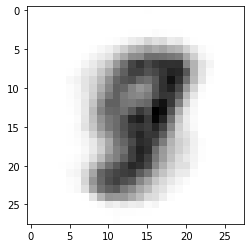

In [174]:
plt.imshow(res[0], cmap='gray_r')

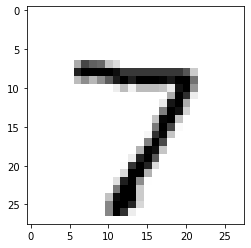

In [175]:
plt.imshow(x_test[0], cmap='gray_r')